In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import odom_utils as odou
from visualization import papermode
from utils import gps_processing as gpsp

# papermode(plt, size=18)

In [2]:
# Parameters
abbr = "R10"


In [3]:
preprocess(abbr, verbose=False)
m2009df = morales2009.morales2009(abbr, verbose=False)
p2014df = pentzer2014pow.pentzer2014pow(abbr, verbose=False)
p2022df = pentzer2022.pentzer2022(abbr, verbose=False)


R10: 100%|██████████| 1152/1152 [00:00<00:00, 6609.93it/s]


In [4]:
basename = u.get_basename(u.get_filename(abbr))
figdir = u.get_figdir(basename, subdir=f"maps")
rundir = u.get_rundir(basename)
gps_df = pd.read_csv(rundir / f"{abbr}-DEMelevation.csv")
gps_df["dist"] = gpsp.compute_traveled_distance(lat=gps_df.Y, lon=gps_df.X)
gps_df["travel_dist"] = gps_df.dist.cumsum()

In [5]:
if not "long" in p2022df.columns.values:
    coords = odou.transform_odom(p2022df.px, p2022df.py, abbr=abbr)
else:
    coords = p2022df[["long", "lat"]].copy().rename(columns={"long": "lon"})

In [6]:
terrain_changeA = 320
terrain_changeB = 750
all_dfs = (m2009df, p2014df, p2022df)
for df in all_dfs:
    df.rename(columns={"long":"lon"},inplace=True)
    df["terrain"] = "snow"
    df["terrain"] = df.terrain.mask(df.index < terrain_changeA, "sandy loam")
    df["terrain"] = df.terrain.mask(df.index > terrain_changeB, "sandy loam")

In [ ]:
terrains = ["sandy loam", "snow"]
terr_cols = {terr: u.COLORS[terr] for terr in terrains}

# $\mu$ vs elevation

Text(0.5, 0, '$\\mu$')

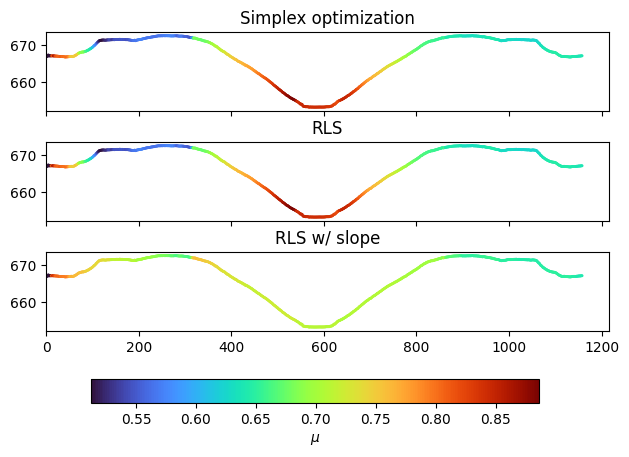

In [7]:
fig, subfigs = plt.subplots(nrows=4, sharex=True)

cseries = pd.concat([df.m_sym.iloc[50:] for df in all_dfs], ignore_index=True)
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

[ax0, ax1, ax2, ax3] = subfigs

sc1 = ax1.scatter(m2009df.time_rel, gps_df.Z, c=scmap.to_rgba(m2009df.m_sym), s=1)
sc2 = ax2.scatter(p2014df.time_rel, gps_df.Z, c=scmap.to_rgba(p2014df.m_sym), s=1)
sc3 = ax3.scatter(p2022df.time_rel, gps_df.Z, c=scmap.to_rgba(p2022df.m_sym), s=1)

ax1.set_title("Simplex optimization")
ax2.set_title("RLS")
ax3.set_title("RLS w/ slope")

ax1.set_xlim(left=0)

fig.tight_layout()

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(scmap, orientation="horizontal", cax=cbar_ax)
cbar_ax.set_xlabel("$\mu$")
# cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)

# for ext in u.EXTS:
#     fig.savefig(figdir / f"{abbr}_msym_map.{ext}", bbox_inches="tight")


# DONE